# Import Libraries

In [76]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier, IsolationForest, RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

# Obtain Data

Read csv file with medal counts into Pandas

In [2]:
medals_df = pd.read_csv('Data/medals.csv')
medals_df.columns = ['Olympic Country', 'Gold', 'Silver', 'Bronze', 'Totals']
print(medals_df.shape)
medals_df.head()

(93, 5)


,Olympic Country,Gold,Silver,Bronze,Totals
0,United States,39,41,33,113
1,China,38,32,18,88
2,Japan,27,14,17,58
3,Great Britain,22,21,22,65
4,Russian Olympic Committee,20,28,23,71


Read csv file with country indicator data into pandas

In [3]:
indicators_df = pd.read_csv('Data/indicators.csv')
indicators_df.columns = ['Indicator Country', 'Health Expenditure (% of GDP)', 'GDP Per Capita', 'Gini Index', 
                         'Education Expenditure (% of GDP)', 'Migrant Population Proportion', 
                         'Air Pollution Exposure', 'Ages 20-24 Female Population Proportion',
                         'Ages 20-24 Male Population Proportion', 'Ages 25-29 Female Population Proportion',
                         'Ages 25-29 Male Population Proportion', 'Ages 30-34 Female Population Proportion',
                         'Ages 30-34 Male Population Proportion', 'Population', 'Urban Population Proportion']
print(indicators_df.shape)
indicators_df.head()

,Indicator Country,Health Expenditure (% of GDP),GDP Per Capita,Gini Index,Education Expenditure (% of GDP),Migrant Population Proportion,Air Pollution Exposure,Ages 20-24 Female Population Proportion,Ages 20-24 Male Population Proportion,Ages 25-29 Female Population Proportion,Ages 25-29 Male Population Proportion,Ages 30-34 Female Population Proportion,Ages 30-34 Male Population Proportion,Population,Urban Population Proportion
0,Afghanistan,9.395727,1978.961579,NaN,3.21378,1.175547,56.910808,10.073862,10.098379,7.907260,8.063549,6.221683,6.503323,38928341.0,26.026000
1,Africa Eastern and Southern,5.925882,3371.814704,NaN,4.71930,1.734768,35.512988,9.218579,9.355607,7.906863,7.947182,6.763558,6.723442,677243299.0,36.783306
2,Africa Western and Central,4.004790,3995.039927,NaN,3.03285,2.079691,58.064482,8.940792,9.041989,7.522335,7.578698,6.425444,6.427822,458803476.0,47.848625
3,Albania,5.262714,13295.410885,33.2,3.94576,1.989036,18.200603,7.853874,8.013442,8.138641,8.828823,7.168070,8.372488,2837743.0,62.112000
4,Algeria,6.218427,10681.679297,27.6,6.10036,0.611072,38.884011,6.769581,6.910889,8.120237,8.179230,8.527349,8.474931,43851043.0,73.733000


Read csv file with list of olympic countries into Pandas

In [4]:
countries_df = pd.read_csv('Data/olympic_countries.csv')
countries_df['Country'] = countries_df['Country'].apply(lambda x: x.strip())
print(countries_df.shape)
countries_df.head()

,Country
0,Afghanistan
1,Albania
2,Algeria
3,American Samoa
4,Andorra


# Scrub Data

View list of countries whose names are different in medals_df and countries_df 

In [5]:
test_df = pd.merge(countries_df, medals_df, left_on='Country', right_on='Olympic Country', how='right')
print(test_df[test_df['Country'].isna()]['Olympic Country'].values)

['United States' 'China' 'Russian Olympic Committee' 'South Korea' 'Iran'
 'Hong Kong' 'Ivory Coast' 'Syria' 'Moldova']


Replace different country names from medals_df with the corresponding name from countries_df and merge the two dfs

In [6]:
countries_replace_dict = {'United States': 'United States of America', 'China': "People's Republic of China",
                          'Russian Olympic Committee': 'ROC*', 'South Korea': 'Republic of Korea', 'Iran':
                          'Islamic Republic of Iran', 'Hong Kong': 'Hong Kong, China', 
                          'Ivory Coast' : "Côte d'Ivoire", 'Syria' : 'Syrian Arab Republic', 
                          'Moldova' : 'Republic of Moldova'}
medals_df['Olympic Country'] = medals_df['Olympic Country'].replace(countries_replace_dict)
df = pd.merge(countries_df, medals_df, left_on='Country', right_on='Olympic Country', how='left')
df.drop(columns='Olympic Country', inplace=True)
print(df.shape)
df.head()

(206, 5)


,Country,Gold,Silver,Bronze,Totals
0,Afghanistan,NaN,NaN,NaN,NaN
1,Albania,NaN,NaN,NaN,NaN
2,Algeria,NaN,NaN,NaN,NaN
3,American Samoa,NaN,NaN,NaN,NaN
4,Andorra,NaN,NaN,NaN,NaN


View list of countries whose names are different in df and indicators_df

In [7]:
test2_df = pd.merge(df, indicators_df, left_on='Country', right_on='Indicator Country', how='left')
print(test2_df[test2_df['Indicator Country'].isna()]['Country'].values)

['Bahamas' 'Cape Verde' 'Chinese Taipei' 'Congo' 'Cook Islands'
 "Côte d'Ivoire" "Democratic People's Republic of Korea"
 'Democratic Republic of the Congo' 'Dominique' 'Egypt'
 'Federated States of Micronesia' 'Gambia' 'Great Britain'
 'Hong Kong, China' 'Islamic Republic of Iran' 'Kyrgyzstan'
 "Lao People's Democratic Republic" 'Palestine'
 "People's Republic of China" 'Republic of Korea' 'Republic of Moldova'
 'ROC*' 'Saint Kitts and Nevis' 'Saint Lucia'
 'Samoa (until 1996 Western Samoa)' 'Slovakia'
 'St Vincent and the Grenadines' 'United Republic of Tanzania'
 'United States of America' 'Venezuela' 'Virgin Islands, British'
 'Virgin Islands, US' 'Yemen']


Replace different country names from indicators_df with the corresponding name from df and merge the two dfs

In [8]:
indicator_replacements_df = pd.read_excel('Data/indicator_countries.xlsx')
indicator_countries = list(indicator_replacements_df['Indicator Country'].values)
indicator_replacements = list(indicator_replacements_df['Country'].values)
indicators_replace_dict = {}
for key, value in zip(indicator_countries, indicator_replacements):
    indicators_replace_dict[key] = value
indicators_df['Indicator Country'] = indicators_df['Indicator Country'].replace(indicators_replace_dict)
df = pd.merge(df, indicators_df, left_on='Country', right_on='Indicator Country', how='inner')
df.drop(columns=['Indicator Country'], inplace=True)
print(df.shape)
df.head()

,Country,Gold,Silver,Bronze,Totals,Health Expenditure (% of GDP),GDP Per Capita,Gini Index,Education Expenditure (% of GDP),Migrant Population Proportion,Air Pollution Exposure,Ages 20-24 Female Population Proportion,Ages 20-24 Male Population Proportion,Ages 25-29 Female Population Proportion,Ages 25-29 Male Population Proportion,Ages 30-34 Female Population Proportion,Ages 30-34 Male Population Proportion,Population,Urban Population Proportion
0,Afghanistan,NaN,NaN,NaN,NaN,9.395727,1978.961579,NaN,3.21378,1.175547,56.910808,10.073862,10.098379,7.907260,8.063549,6.221683,6.503323,38928341.0,26.026
1,Albania,NaN,NaN,NaN,NaN,5.262714,13295.410885,33.2,3.94576,1.989036,18.200603,7.853874,8.013442,8.138641,8.828823,7.168070,8.372488,2837743.0,62.112
2,Algeria,NaN,NaN,NaN,NaN,6.218427,10681.679297,27.6,6.10036,0.611072,38.884011,6.769581,6.910889,8.120237,8.179230,8.527349,8.474931,43851043.0,73.733
3,American Samoa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.802009,12.473820,NaN,NaN,NaN,NaN,NaN,NaN,55197.0,87.153
4,Andorra,NaN,NaN,NaN,NaN,6.710331,NaN,NaN,3.15061,59.713649,10.307621,NaN,NaN,NaN,NaN,NaN,NaN,77265.0,87.916


Dop columns not useful for modeling

In [9]:
df.drop(columns=['Gold', 'Silver', 'Bronze'], inplace=True)
df.head()

,Country,Totals,Health Expenditure (% of GDP),GDP Per Capita,Gini Index,Education Expenditure (% of GDP),Migrant Population Proportion,Air Pollution Exposure,Ages 20-24 Female Population Proportion,Ages 20-24 Male Population Proportion,Ages 25-29 Female Population Proportion,Ages 25-29 Male Population Proportion,Ages 30-34 Female Population Proportion,Ages 30-34 Male Population Proportion,Population,Urban Population Proportion
0,Afghanistan,NaN,9.395727,1978.961579,NaN,3.21378,1.175547,56.910808,10.073862,10.098379,7.907260,8.063549,6.221683,6.503323,38928341.0,26.026
1,Albania,NaN,5.262714,13295.410885,33.2,3.94576,1.989036,18.200603,7.853874,8.013442,8.138641,8.828823,7.168070,8.372488,2837743.0,62.112
2,Algeria,NaN,6.218427,10681.679297,27.6,6.10036,0.611072,38.884011,6.769581,6.910889,8.120237,8.179230,8.527349,8.474931,43851043.0,73.733
3,American Samoa,NaN,NaN,NaN,NaN,NaN,41.802009,12.473820,NaN,NaN,NaN,NaN,NaN,NaN,55197.0,87.153
4,Andorra,NaN,6.710331,NaN,NaN,3.15061,59.713649,10.307621,NaN,NaN,NaN,NaN,NaN,NaN,77265.0,87.916


Calculate Ages 20-34 Population Proportion interaction between features and drop columns used to calculate interaction

In [10]:
df['Ages 20-34 Population Proportion'] = ((df['Ages 20-24 Female Population Proportion'] +
                                           df['Ages 25-29 Female Population Proportion'] + 
                                           df['Ages 30-34 Female Population Proportion'])
                                          +
                                          (df['Ages 20-24 Male Population Proportion'] + 
                                           df['Ages 25-29 Male Population Proportion'] + 
                                           df['Ages 30-34 Male Population Proportion']))/2
df.drop(columns=['Ages 20-24 Female Population Proportion', 'Ages 20-24 Male Population Proportion',
                'Ages 25-29 Female Population Proportion', 'Ages 25-29 Male Population Proportion',
                'Ages 30-34 Female Population Proportion', 'Ages 30-34 Male Population Proportion'], inplace=True)
df.head()

,Country,Totals,Health Expenditure (% of GDP),GDP Per Capita,Gini Index,Education Expenditure (% of GDP),Migrant Population Proportion,Air Pollution Exposure,Population,Urban Population Proportion,Ages 20-34 Population Proportion
0,Afghanistan,NaN,9.395727,1978.961579,NaN,3.21378,1.175547,56.910808,38928341.0,26.026,24.434028
1,Albania,NaN,5.262714,13295.410885,33.2,3.94576,1.989036,18.200603,2837743.0,62.112,24.187669
2,Algeria,NaN,6.218427,10681.679297,27.6,6.10036,0.611072,38.884011,43851043.0,73.733,23.491109
3,American Samoa,NaN,NaN,NaN,NaN,NaN,41.802009,12.473820,55197.0,87.153,NaN
4,Andorra,NaN,6.710331,NaN,NaN,3.15061,59.713649,10.307621,77265.0,87.916,NaN


use df.info to see what further scrubbing needed

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 203 entries, 0 to 202
Data columns (total 11 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Country                           203 non-null    object 
 1   Totals                            92 non-null     float64
 2   Health Expenditure (% of GDP)     189 non-null    float64
 3   GDP Per Capita                    188 non-null    float64
 4   Gini Index                        153 non-null    float64
 5   Education Expenditure (% of GDP)  177 non-null    float64
 6   Migrant Population Proportion     202 non-null    float64
 7   Air Pollution Exposure            191 non-null    float64
 8   Population                        203 non-null    float64
 9   Urban Population Proportion       202 non-null    float64
 10  Ages 20-34 Population Proportion  189 non-null    float64
dtypes: float64(10), object(1)
memory usage: 19.0+ KB


Replace NaN values in Totals column with 0

In [12]:
totals_replace_dict = {np.nan: 0}
df['Totals'] = df['Totals'].replace(totals_replace_dict)
df.head()

,Country,Totals,Health Expenditure (% of GDP),GDP Per Capita,Gini Index,Education Expenditure (% of GDP),Migrant Population Proportion,Air Pollution Exposure,Population,Urban Population Proportion,Ages 20-34 Population Proportion
0,Afghanistan,0.0,9.395727,1978.961579,NaN,3.21378,1.175547,56.910808,38928341.0,26.026,24.434028
1,Albania,0.0,5.262714,13295.410885,33.2,3.94576,1.989036,18.200603,2837743.0,62.112,24.187669
2,Algeria,0.0,6.218427,10681.679297,27.6,6.10036,0.611072,38.884011,43851043.0,73.733,23.491109
3,American Samoa,0.0,NaN,NaN,NaN,NaN,41.802009,12.473820,55197.0,87.153,NaN
4,Andorra,0.0,6.710331,NaN,NaN,3.15061,59.713649,10.307621,77265.0,87.916,NaN


Drop rows missing 4 or more features

In [13]:
df.drop(index=df[df.isna().sum(axis=1)>=4].index, inplace=True)
df.reset_index(drop=True, inplace=True)
df.head()

,Country,Totals,Health Expenditure (% of GDP),GDP Per Capita,Gini Index,Education Expenditure (% of GDP),Migrant Population Proportion,Air Pollution Exposure,Population,Urban Population Proportion,Ages 20-34 Population Proportion
0,Afghanistan,0.0,9.395727,1978.961579,NaN,3.21378,1.175547,56.910808,38928341.0,26.026,24.434028
1,Albania,0.0,5.262714,13295.410885,33.2,3.94576,1.989036,18.200603,2837743.0,62.112,24.187669
2,Algeria,0.0,6.218427,10681.679297,27.6,6.10036,0.611072,38.884011,43851043.0,73.733,23.491109
3,Andorra,0.0,6.710331,NaN,NaN,3.15061,59.713649,10.307621,77265.0,87.916,NaN
4,Angola,0.0,2.549005,6198.083841,51.3,1.82118,0.427005,32.388505,32866268.0,66.825,22.352392


Impute missing values

In [14]:
impute_df = df.drop(columns=['Country'])
impute_x = impute_df.drop(columns=['Totals'])
impute_y = impute_df['Totals']
impute_x_train, impute_x_test, impute_y_train, impute_y_test = train_test_split(impute_x, impute_y
                                                                                , random_state=15, test_size=.3)
impute_ss = StandardScaler()
impute_ss.fit(impute_x_train)
impute_x_train = pd.DataFrame(impute_ss.transform(impute_x_train), columns=impute_x_train.columns)
impute_x_test = pd.DataFrame(impute_ss.transform(impute_x_test), columns=impute_x_test.columns)

train_imputer = KNNImputer()
impute_x_train = pd.DataFrame(train_imputer.fit_transform(impute_x_train), columns=impute_x.columns)
impute_x_train = pd.DataFrame(impute_ss.inverse_transform(impute_x_train), columns = impute_x_train.columns)
impute_x_train.index = impute_y_train.index

test_imputer = KNNImputer()
impute_x_test = pd.DataFrame(test_imputer.fit_transform(impute_x_test), columns=impute_x.columns)
impute_x_test = pd.DataFrame(impute_ss.inverse_transform(impute_x_test), columns = impute_x_test.columns)
impute_x_test.index = impute_y_test.index

scrubbed_df = pd.concat([impute_x_train, impute_x_test], axis=0)
scrubbed_df.sort_index(inplace=True)
scrubbed_df['Medals'] = df['Totals']

Convert number of medals won varaible into medals won class variable

In [15]:
scrubbed_df['Medals'] = scrubbed_df['Medals'].astype(bool).astype(int)
scrubbed_df.head()

,Health Expenditure (% of GDP),GDP Per Capita,Gini Index,Education Expenditure (% of GDP),Migrant Population Proportion,Air Pollution Exposure,Population,Urban Population Proportion,Ages 20-34 Population Proportion,Medals
0,9.395727,1978.961579,40.64,3.21378,1.175547,56.910808,38928341.0,26.026,24.434028,0
1,5.262714,13295.410885,33.20,3.94576,1.989036,18.200603,2837743.0,62.112,24.187669,0
2,6.218427,10681.679297,27.60,6.10036,0.611072,38.884011,43851043.0,73.733,23.491109,0
3,6.710331,56175.341171,32.34,3.15061,59.713649,10.307621,77265.0,87.916,22.409830,0
4,2.549005,6198.083841,51.30,1.82118,0.427005,32.388505,32866268.0,66.825,22.352392,0


Confirm data now scrubbed with scrubbed_df.info()

In [16]:
scrubbed_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 193 entries, 0 to 192
Data columns (total 10 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Health Expenditure (% of GDP)     193 non-null    float64
 1   GDP Per Capita                    193 non-null    float64
 2   Gini Index                        193 non-null    float64
 3   Education Expenditure (% of GDP)  193 non-null    float64
 4   Migrant Population Proportion     193 non-null    float64
 5   Air Pollution Exposure            193 non-null    float64
 6   Population                        193 non-null    float64
 7   Urban Population Proportion       193 non-null    float64
 8   Ages 20-34 Population Proportion  193 non-null    float64
 9   Medals                            193 non-null    int32  
dtypes: float64(9), int32(1)
memory usage: 15.8 KB


# Explore Data

Build Isolation Forest Model

In [17]:
isf_x = scrubbed_df.drop(columns=['Medals'])
isf_y = scrubbed_df['Medals']
isf_x_train, isf_x_test, isf_y_train, isf_y_test = train_test_split(isf_x, isf_y, random_state=15, test_size=.3)


isf_ss = StandardScaler()
ss_isf_x_train = pd.DataFrame(isf_ss.fit_transform(isf_x_train), columns=isf_x_train.columns)
isolation_forest = IsolationForest(contamination=.05)
ss_isf_x_train['Outlier'] = isolation_forest.fit_predict(ss_isf_x_train)
ss_isf_x_train[ss_isf_x_train['Outlier']==-1].round(decimals=1).drop(columns='Outlier')

C:\Users\blant\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


,Health Expenditure (% of GDP),GDP Per Capita,Gini Index,Education Expenditure (% of GDP),Migrant Population Proportion,Air Pollution Exposure,Population,Urban Population Proportion,Ages 20-34 Population Proportion
1,-1.5,3.2,-0.6,-0.6,4.2,3.2,-0.2,1.8,3.7
10,-0.9,1.1,-0.7,-1.1,2.7,2.1,-0.3,1.4,2.7
30,-0.4,4.4,-0.3,-0.3,2.2,-1.0,-0.3,1.5,-0.4
44,-0.5,1.5,-0.4,1.3,4.1,1.6,-0.2,1.9,-1.0
106,-0.8,2.3,-1.7,-0.7,5.1,0.6,-0.2,1.3,3.7
112,-1.1,-0.6,-0.3,-0.5,-0.6,3.1,7.8,-1.0,0.6
118,1.1,-0.3,-0.9,-0.1,1.0,-1.1,-0.3,-0.7,3.8


Replace all dataset values greater than 4 standard deviations from the mean with the 4 standard deviation value

In [18]:
replacement_x = scrubbed_df.drop(columns=['Medals'])
replacement_y = scrubbed_df['Medals']
replacement_x_train, replacement_x_test, replacement_y_train, replacement_y_test = train_test_split(
    replacement_x, replacement_y, random_state=15, test_size=.3)
replacement_train_index = replacement_x_train.index
replacement_test_index = replacement_x_test.index

replacement_ss = StandardScaler()
replacement_ss.fit(replacement_x_train)
replacement_x_train = pd.DataFrame(replacement_ss.transform(replacement_x_train), columns=replacement_x_train.columns)
replacement_x_test = pd.DataFrame(replacement_ss.transform(replacement_x_test), columns=replacement_x_test.columns)

def replace_outliers(row):
    output_row = []
    for val in row.values:
        if val > 4:
            output_row.append(4)
        elif val < -4:
            output_row.append(-4)
        else:
            output_row.append(val)
    return pd.Series(output_row, index=row.index)
            
replacement_x_train = replacement_x_train.apply(replace_outliers, axis=1)
replacement_x_train = pd.DataFrame(replacement_ss.inverse_transform(replacement_x_train), 
                                   columns=replacement_x_train.columns, index=replacement_train_index)

replacement_x_test = replacement_x_test.apply(replace_outliers, axis=1)
replacement_x_test = pd.DataFrame(replacement_ss.inverse_transform(replacement_x_test), 
                                   columns=replacement_x_test.columns, index=replacement_test_index)

scrubbed_df = pd.concat([replacement_x_train, replacement_x_test])
scrubbed_df.sort_index(inplace=True)
scrubbed_df['Medals'] = replacement_y
scrubbed_df.head()

,Health Expenditure (% of GDP),GDP Per Capita,Gini Index,Education Expenditure (% of GDP),Migrant Population Proportion,Air Pollution Exposure,Population,Urban Population Proportion,Ages 20-34 Population Proportion,Medals
0,9.395727,1978.961579,40.64,3.21378,1.175547,56.910808,38928341.0,26.026,24.434028,0
1,5.262714,13295.410885,33.20,3.94576,1.989036,18.200603,2837743.0,62.112,24.187669,0
2,6.218427,10681.679297,27.60,6.10036,0.611072,38.884011,43851043.0,73.733,23.491109,0
3,6.710331,56175.341171,32.34,3.15061,59.713649,10.307621,77265.0,87.916,22.409830,0
4,2.549005,6198.083841,51.30,1.82118,0.427005,32.388505,32866268.0,66.825,22.352392,0


Calculate descriptive statistics for each feature in scrubbed_df

In [19]:
scrubbed_df.describe()

,Health Expenditure (% of GDP),GDP Per Capita,Gini Index,Education Expenditure (% of GDP),Migrant Population Proportion,Air Pollution Exposure,Population,Urban Population Proportion,Ages 20-34 Population Proportion,Medals
count,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,1.930000e+02,193.000000,193.000000,193.000000
mean,6.586354,19920.396340,37.710570,4.439209,9.010892,27.422076,3.301634e+07,59.698886,23.136350,0.471503
std,2.795532,20293.234967,7.084946,1.815966,13.286797,18.764016,8.544769e+07,23.202675,3.743198,0.500486
min,2.138482,731.063230,24.600000,1.324960,0.071076,5.861331,1.083400e+04,13.345000,14.989765,0.000000
25%,4.471785,4916.721381,32.800000,3.234370,1.251345,13.909543,2.142252e+06,42.198000,20.593360,0.000000
50%,6.330850,12377.017293,36.800000,4.163390,3.682771,22.196055,8.917205e+06,59.453000,23.484794,0.000000
75%,8.253421,28832.623149,41.600000,5.262050,11.695683,35.557453,2.913681e+07,78.297000,24.993606,1.000000
max,17.191594,101279.202067,63.000000,11.147573,71.851801,99.734374,7.277118e+08,100.000000,38.605706,1.000000


Plot class distribution for Medals variable

[Text(0, 0, 'Not Won'), Text(1, 0, 'Won')]

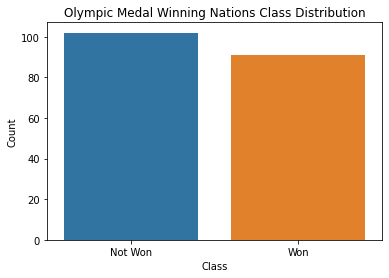

In [318]:
fig, ax = plt.subplots()
sns.countplot(x='Medals',data=scrubbed_df, ax=ax)
ax.set_title('Olympic Medal Winning Nations Class Distribution')
ax.set_xlabel('Class')
ax.set_ylabel('Count')
ax.set_xticklabels(['Not Won', 'Won'])

Plot distribution for each independent variable

C:\Users\blant\AppData\Roaming\Python\Python39\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\blant\AppData\Roaming\Python\Python39\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\blant\AppData\Roaming\Python\Python39\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level functio

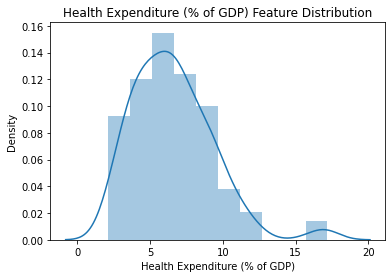

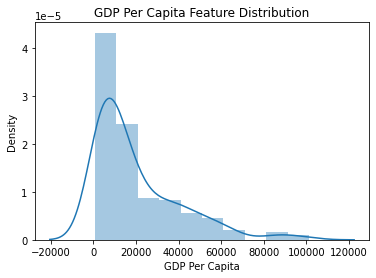

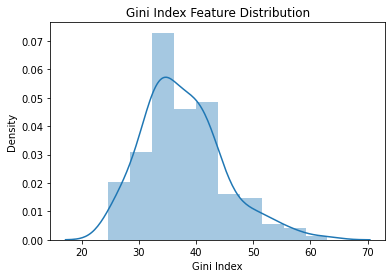

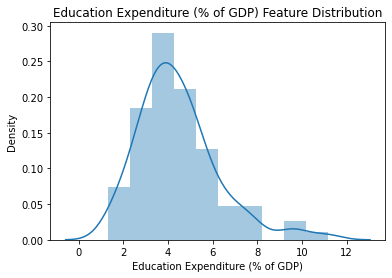

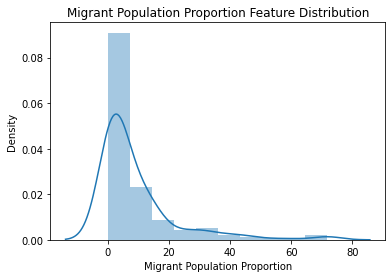

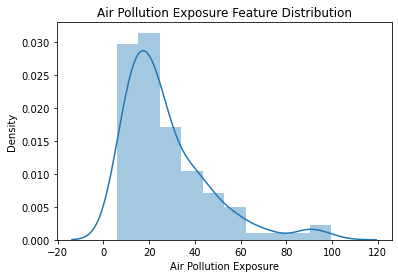

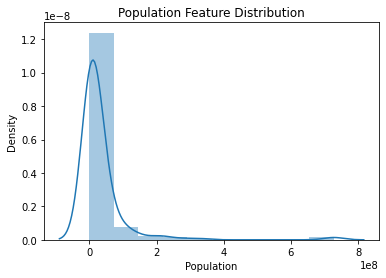

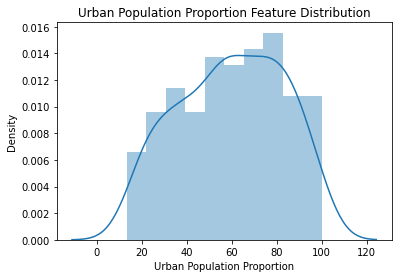

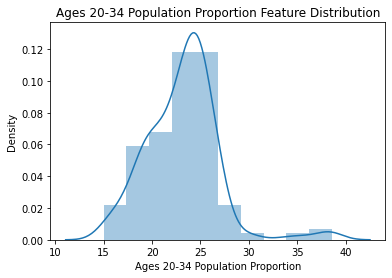

In [21]:
features = list(scrubbed_df.columns)
features.remove('Medals')
for feat in features:
    fig, ax = plt.subplots()
    sns.distplot(scrubbed_df[feat], kde=True, bins=10, ax=ax)
    ax.set_title(f'{feat} Feature Distribution')

Calculate vif for each feature to confirm no correlated features need to be dropped

In [325]:
vif_df = add_constant(scrubbed_df.drop(columns='Medals'))
vif_output = []
for num in range(0, len(vif_df.columns)):
    vif_output.append([vif_df.columns[num], variance_inflation_factor(vif_df.values, num)])
vif_output_df = pd.DataFrame(vif_output, columns=['Column', 'VIF'])
vif_output_df.sort_values(by='VIF', ascending=False, inplace=True)
vif_output_df.round(1)

,Column,VIF
0,const,111.9
2,GDP Per Capita,3.3
5,Migrant Population Proportion,2.6
8,Urban Population Proportion,1.8
9,Ages 20-34 Population Proportion,1.7
6,Air Pollution Exposure,1.6
1,Health Expenditure (% of GDP),1.6
4,Education Expenditure (% of GDP),1.4
3,Gini Index,1.3
7,Population,1.2


# Model Data

Create x and y variables

In [23]:
x = scrubbed_df.drop(columns='Medals')
y = scrubbed_df['Medals']

Perform train test split on x and y variables

In [24]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=15, test_size=.3)

Standard scale data

In [25]:
ss = StandardScaler()
ss.fit(x_train)
x_train = pd.DataFrame(ss.transform(x_train), columns=x_train.columns)
x_test = pd.DataFrame(ss.transform(x_test), columns=x_test.columns)

Fit and evaluate dummy classifier model

In [26]:
dc = DummyClassifier(strategy='stratified', random_state=37)
dc.fit(x_train, y_train)
y_train_pred_dc = dc.predict(x_train)
y_test_pred_dc = dc.predict(x_test)
print('Dummy Classifier')
print('Train f1 score', f1_score(y_train, y_train_pred_dc))
print('Train Accuracy score', accuracy_score(y_train, y_train_pred_dc))
print('Test f1 score', f1_score(y_test, y_test_pred_dc))
print('Test Accuracy score', accuracy_score(y_test, y_test_pred_dc))

Dummy Classifier
Train f1 score 0.5413533834586466
Train Accuracy score 0.5481481481481482
Test f1 score 0.4838709677419355
Test Accuracy score 0.4482758620689655


Gridsearch logistic regression model

In [27]:
gs_lr_dict = {'C': [x/100 for x in range(10,51)]}
gs_lr_model = LogisticRegression()
gs_lr = GridSearchCV(estimator=gs_lr_model, param_grid=gs_lr_dict, scoring='f1', n_jobs=-1, cv=5, verbose=1)
gs_lr.fit(x_train, y_train)
print('Logistic Regression Gridsearch')
print('Best score:', gs_lr.best_score_)
print('Best params:', gs_lr.best_params_)

Fitting 5 folds for each of 41 candidates, totalling 205 fits
Logistic Regression Gridsearch
Best score: 0.6798029556650247
Best params: {'C': 0.31}


Fit and evaluate top performing logistic regression model

In [28]:
lr = LogisticRegression(C=.31)
lr.fit(x_train, y_train)
y_train_pred_lr = lr.predict(x_train)
y_test_pred_lr = lr.predict(x_test)
print('Logistic Regression')
print('Train f1 score', f1_score(y_train, y_train_pred_lr))
print('Train Accuracy score', accuracy_score(y_train, y_train_pred_lr))
print('Test f1 score', f1_score(y_test, y_test_pred_lr))
print('Test Accuracy score', accuracy_score(y_test, y_test_pred_lr))

Logistic Regression
Train f1 score 0.7368421052631577
Train Accuracy score 0.7777777777777778
Test f1 score 0.73015873015873
Test Accuracy score 0.7068965517241379


Plot logistic regression confusion matrix

[Text(0, 0.5, 'Not Won'), Text(0, 1.5, 'Won')]

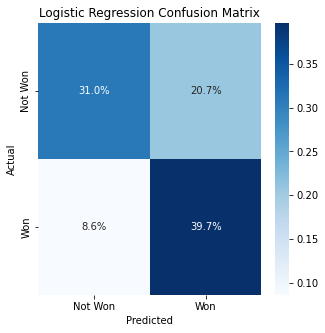

In [29]:
lr_cm = confusion_matrix(y_test, y_test_pred_lr)
fig, ax = plt.subplots(figsize=(5,5))
lr_matrix = sns.heatmap(lr_cm/np.sum(lr_cm), annot=True, ax = ax, cmap = 'Blues', fmt = '.1%')
lr_matrix.set_title('Logistic Regression Confusion Matrix')
lr_matrix.set_xlabel('Predicted')
lr_matrix.set_xticklabels(['Not Won','Won'])
lr_matrix.set_ylabel('Actual')
lr_matrix.set_yticklabels(['Not Won','Won'])

Gridsearch adaboost model

In [30]:
gs_ab_dict = {'learning_rate': [x/100 for x in range(100, 151)]}
gs_ab_model = AdaBoostClassifier()
gs_ab = GridSearchCV(estimator=gs_ab_model, param_grid=gs_ab_dict, scoring='f1', n_jobs=-1, cv=5, verbose=1)
gs_ab.fit(x_train, y_train)
print('Adaboost Gridsearch')
print('Best score:', gs_ab.best_score_)
print('Best params:', gs_ab.best_params_)

Fitting 5 folds for each of 51 candidates, totalling 255 fits
Adaboost Gridsearch
Best score: 0.8055406911928651
Best params: {'learning_rate': 1.2}


Fite and evaluate top performing adaboost model

In [31]:
ab = AdaBoostClassifier(learning_rate=1.2)
ab.fit(x_train, y_train)
y_train_pred_ab = ab.predict(x_train)
y_test_pred_ab = ab.predict(x_test)
print('Adaboost Classifier')
print('Train f1 score', f1_score(y_train, y_train_pred_ab))
print('Train Accuracy score', accuracy_score(y_train, y_train_pred_ab))
print('Test f1 score', f1_score(y_test, y_test_pred_ab))
print('Test Accuracy score', accuracy_score(y_test, y_test_pred_ab))

Adaboost Classifier
Train f1 score 1.0
Train Accuracy score 1.0
Test f1 score 0.6885245901639345
Test Accuracy score 0.6724137931034483


Plot adaboost confusion matrix

[Text(0, 0.5, 'Not Won'), Text(0, 1.5, 'Won')]

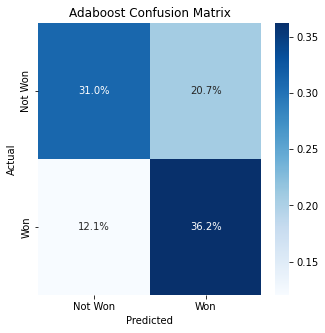

In [32]:
ab_cm = confusion_matrix(y_test, y_test_pred_ab)
fig, ax = plt.subplots(figsize=(5,5))
ab_matrix = sns.heatmap(ab_cm/np.sum(ab_cm), annot=True, ax = ax, cmap = 'Blues', fmt = '.1%')
ab_matrix.set_title('Adaboost Confusion Matrix')
ab_matrix.set_xlabel('Predicted')
ab_matrix.set_xticklabels(['Not Won','Won'])
ab_matrix.set_ylabel('Actual')
ab_matrix.set_yticklabels(['Not Won','Won'])

Gridsearch random forest classifier

In [33]:
gs_rf_dict = {'max_features': [.01, .02, .03, .04, .05],
             'max_samples': [.73, .735, .74, .745, .75],
             'min_samples_split': [3, 4, 5, 6, 7],
             'criterion': ['gini', 'entropy']}
gs_rf_model = RandomForestClassifier(random_state=27)
gs_rf = GridSearchCV(estimator=gs_rf_model, param_grid=gs_rf_dict, scoring='f1', n_jobs=-1, cv=5, verbose=1)
gs_rf.fit(x_train, y_train)
print('Random Forest')
print('Best score:', gs_rf.best_score_)
print('Best params:', gs_rf.best_params_)

Fitting 5 folds for each of 250 candidates, totalling 1250 fits
Random Forest
Best score: 0.7362666319188058
Best params: {'criterion': 'entropy', 'max_features': 0.01, 'max_samples': 0.74, 'min_samples_split': 5}


Fit and evaluate top performing random forest classifier

In [34]:
rf = RandomForestClassifier(criterion='entropy', max_features=0.005, max_samples=0.74, min_samples_split=5,
                           random_state=27)
rf.fit(x_train, y_train)
y_train_pred_rf = rf.predict(x_train)
y_test_pred_rf = rf.predict(x_test)
print('Random Forest Classifier')
print('Train f1 score', f1_score(y_train, y_train_pred_rf))
print('Train Accuracy score', accuracy_score(y_train, y_train_pred_rf))
print('Test f1 score', f1_score(y_test, y_test_pred_rf))
print('Test Accuracy score', accuracy_score(y_test, y_test_pred_rf))

Random Forest Classifier
Train f1 score 0.9838709677419354
Train Accuracy score 0.9851851851851852
Test f1 score 0.7636363636363638
Test Accuracy score 0.7758620689655172


Plot random forest confusion matrix

[Text(0, 0.5, 'Not Won'), Text(0, 1.5, 'Won')]

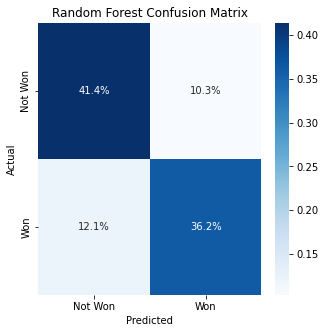

In [35]:
rf_cm = confusion_matrix(y_test, y_test_pred_rf)
fig, ax = plt.subplots(figsize=(5,5))
rf_matrix = sns.heatmap(rf_cm/np.sum(rf_cm), annot=True, ax = ax, cmap = 'Blues', fmt = '.1%')
rf_matrix.set_title('Random Forest Confusion Matrix')
rf_matrix.set_xlabel('Predicted')
rf_matrix.set_xticklabels(['Not Won','Won'])
rf_matrix.set_ylabel('Actual')
rf_matrix.set_yticklabels(['Not Won','Won'])

Gridsearch xgboost model

In [65]:
xgb_gs_dic = {'colsample_bytree': [.44, .445, .45, .455, .46],
              'gamma': [.59, .595, .6, .605, .61],
              'learning_rate': [.24, .245, .25, .255, .26],
              'reg_lambda': [3.9, 3.95, 4, 4.05, 4.1], 
              'subsample': [.59, .595, .6, .605, .61]}
xgb_gs_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_gs = GridSearchCV(xgb_gs_model, xgb_gs_dic, scoring='f1', cv=5, verbose=1, n_jobs=1)
xgb_gs.fit(x_train, y_train)
print('XGBoost Gridsearch')
print('Best Params', xgb_gs.best_params_)
print('Best Score', xgb_gs.best_score_)

Fitting 5 folds for each of 3125 candidates, totalling 15625 fits
XGBoost Gridsearch
Best Params {'colsample_bytree': 0.445, 'gamma': 0.6, 'learning_rate': 0.25, 'reg_lambda': 4, 'subsample': 0.6}
Best Score 0.8114645354645355


Fit and evaluate top performing xgboost classifier

In [66]:
xgb = XGBClassifier(colsample_bytree= .445, gamma=.6, learning_rate=.25, reg_lambda=4, subsample=.6, random_state=42)
xgb.fit(x_train, y_train)
y_train_pred_xgb = xgb.predict(x_train)
y_test_pred_xgb = xgb.predict(x_test)
print('XGBoost')
print('Train f1 score', f1_score(y_train, y_train_pred_xgb))
print('Train Accuracy score', accuracy_score(y_train, y_train_pred_xgb))
print('Test f1 score', f1_score(y_test, y_test_pred_xgb))
print('Test Accuracy score', accuracy_score(y_test, y_test_pred_xgb))

[13:34:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBoost
Train f1 score 0.975609756097561
Train Accuracy score 0.9777777777777777
Test f1 score 0.7333333333333334
Test Accuracy score 0.7241379310344828


C:\Users\blant\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Plot xgboost confusion matrix

[Text(0, 0.5, 'Not Won'), Text(0, 1.5, 'Won')]

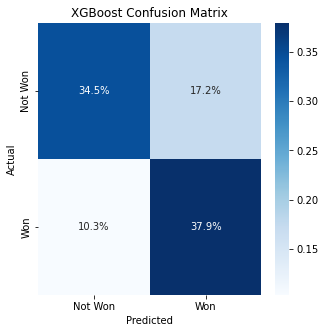

In [120]:
xgb_cm = confusion_matrix(y_test, y_test_pred_xgb)
fig, ax = plt.subplots(figsize=(5,5))
xgb_matrix = sns.heatmap(xgb_cm/np.sum(xgb_cm), annot=True, ax = ax, cmap = 'Blues', fmt = '.1%')
xgb_matrix.set_title('XGBoost Confusion Matrix')
xgb_matrix.set_xlabel('Predicted')
xgb_matrix.set_xticklabels(['Not Won','Won'])
xgb_matrix.set_ylabel('Actual')
xgb_matrix.set_yticklabels(['Not Won','Won'])

Gridsearch svm model

In [96]:
svm_gs_dic = {'C': [x for x in range(100, 201)],
              'gamma': [x/1000 for x in range(0, 51)]}
svm_gs_model = SVC(random_state=53, kernel= 'rbf')
svm_gs = GridSearchCV(svm_gs_model, svm_gs_dic, scoring='f1', cv=5, verbose=1, n_jobs=1)
svm_gs.fit(x_train, y_train)
print('SVM')
print('Best Params', svm_gs.best_params_)
print('Best Score', svm_gs.best_score_)

Fitting 5 folds for each of 5151 candidates, totalling 25755 fits
SVM
Best Params {'C': 140, 'gamma': 0.034}
Best Score 0.7452680652680652


Fit and evaluate top performing svm model

In [259]:
svm = SVC(C=140, gamma=.034, probability=True, random_state=53)
svm.fit(x_train, y_train)
y_train_pred_svm = svm.predict(x_train)
y_test_pred_svm = svm.predict(x_test)
print('SVM')
print('Train f1 score', f1_score(y_train, y_train_pred_svm))
print('Train Accuracy score', accuracy_score(y_train, y_train_pred_svm))
print('Test f1 score', f1_score(y_test, y_test_pred_svm))
print('Test Accuracy score', accuracy_score(y_test, y_test_pred_svm))

SVM
Train f1 score 0.9075630252100839
Train Accuracy score 0.9185185185185185
Test f1 score 0.7719298245614034
Test Accuracy score 0.7758620689655172


Plot svm confusion matrix

[Text(0, 0.5, 'Not Won'), Text(0, 1.5, 'Won')]

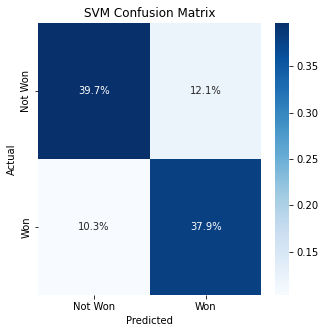

In [121]:
svm_cm = confusion_matrix(y_test, y_test_pred_svm)
fig, ax = plt.subplots(figsize=(5,5))
svm_matrix = sns.heatmap(svm_cm/np.sum(svm_cm), annot=True, ax = ax, cmap = 'Blues', fmt = '.1%')
svm_matrix.set_title('SVM Confusion Matrix')
svm_matrix.set_xlabel('Predicted')
svm_matrix.set_xticklabels(['Not Won','Won'])
svm_matrix.set_ylabel('Actual')
svm_matrix.set_yticklabels(['Not Won','Won'])

Build and evaluate voting classifier

In [311]:
vc = VotingClassifier(estimators=[('svm', svm), ('xgb', xgb)], voting='soft', weights=[.9, .1])
vc.fit(x_train, y_train)
y_train_pred_vc = vc.predict(x_train)
y_test_pred_vc = vc.predict(x_test)
print('Voting Classifier')
print('Train f1 score', f1_score(y_train, y_train_pred_vc))
print('Train Accuracy score', accuracy_score(y_train, y_train_pred_vc))
print('Test f1 score', f1_score(y_test, y_test_pred_vc))
print('Test Accuracy score', accuracy_score(y_test, y_test_pred_vc))

C:\Users\blant\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[07:14:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Voting Classifier
Train f1 score 0.905982905982906
Train Accuracy score 0.9185185185185185
Test f1 score 0.7999999999999999
Test Accuracy score 0.8103448275862069


Plot voting classifier confusion matrix

[Text(0, 0.5, 'Not Won'), Text(0, 1.5, 'Won')]

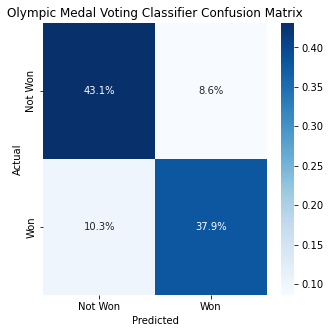

In [327]:
vc_cm = confusion_matrix(y_test, y_test_pred_vc)
fig, ax = plt.subplots(figsize=(5,5))
vc_matrix = sns.heatmap(vc_cm/np.sum(vc_cm), annot=True, ax = ax, cmap = 'Blues', fmt = '.1%')
vc_matrix.set_title('Olympic Medal Voting Classifier Confusion Matrix')
vc_matrix.set_xlabel('Predicted')
vc_matrix.set_xticklabels(['Not Won','Won'])
vc_matrix.set_ylabel('Actual')
vc_matrix.set_yticklabels(['Not Won','Won'])

# Analyze Results

Create df with logistic regression feature coefficients

In [253]:
lr_coefficients_df = pd.DataFrame(lr.coef_, columns=x_train.columns).T.round(2)
lr_coefficients_df.sort_values(by=0, inplace=True, ascending=False)
lr_coefficients_df.reset_index(inplace=True)
lr_coefficients_df.columns = ['Feature', 'Coefficient']
lr_coefficients_df

,Feature,Coefficient
0,Population,0.81
1,Urban Population Proportion,0.70
2,Education Expenditure (% of GDP),0.48
3,GDP Per Capita,0.46
4,Air Pollution Exposure,-0.03
5,Health Expenditure (% of GDP),-0.10
6,Gini Index,-0.10
7,Migrant Population Proportion,-0.33
8,Ages 20-34 Population Proportion,-0.43


Plot logistic regression feature coefficients

[Text(0, 0, 'Population'),
 Text(1, 0, 'Urban\n Population Proportion'),
 Text(2, 0, 'Education Expenditure\n (% of GDP)'),
 Text(3, 0, 'GDP Per Capita'),
 Text(4, 0, 'Air Pollution Exposure'),
 Text(5, 0, 'Health Expenditure\n (% of GDP)'),
 Text(6, 0, 'Gini Index'),
 Text(7, 0, 'Migrant\n Population Proportion'),
 Text(8, 0, 'Ages 20-34\n Population Proportion')]

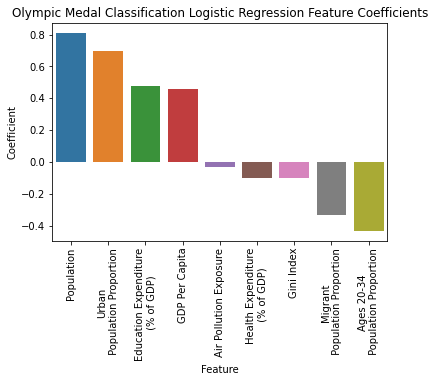

In [337]:
fig, ax = plt.subplots()
sns.barplot(x='Feature', y='Coefficient', data=lr_coefficients_df, ax=ax)
ax.set_xticklabels(lr_coefficients_df['Feature'], rotation=90)
ax.set_title('Olympic Medal Classification Logistic Regression Feature Coefficients')
x_tick_labels = ['Population', 'Urban\n Population Proportion',
       'Education Expenditure\n (% of GDP)', 'GDP Per Capita',
       'Air Pollution Exposure', 'Health Expenditure\n (% of GDP)',
       'Gini Index', 'Migrant\n Population Proportion',
       'Ages 20-34\n Population Proportion'] 
ax.set_xticklabels(x_tick_labels)

Calculate random forest feature importances

In [255]:
rf_importances_df = pd.DataFrame(rf.feature_importances_, columns=['Importance']).round(2)
rf_importances_df['Feature'] = x_train.columns
rf_importances_df.sort_values(by='Importance', inplace=True, ascending=False)
rf_importances_df

,Importance,Feature
6,0.15,Population
1,0.13,GDP Per Capita
7,0.13,Urban Population Proportion
8,0.12,Ages 20-34 Population Proportion
4,0.11,Migrant Population Proportion
3,0.10,Education Expenditure (% of GDP)
2,0.09,Gini Index
5,0.09,Air Pollution Exposure
0,0.08,Health Expenditure (% of GDP)


Plot random forest feature importances

Text(0.5, 1.0, 'Olympic Medal Classification Random Forest Feature Importances')

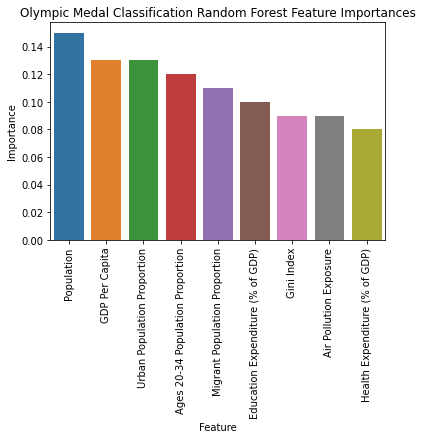

In [313]:
fig, ax = plt.subplots()
sns.barplot(x='Feature', y='Importance', data=rf_importances_df, estimator=np.median, ax=ax)
ax.set_xticklabels(rf_importances_df['Feature'], rotation=90)
ax.set_title('Olympic Medal Classification Random Forest Feature Importances')

In [329]:
lr_coefficients_df['Feature'].values

array(['Population', 'Urban Population Proportion',
       'Education Expenditure (% of GDP)', 'GDP Per Capita',
       'Air Pollution Exposure', 'Health Expenditure (% of GDP)',
       'Gini Index', 'Migrant Population Proportion',
       'Ages 20-34 Population Proportion'], dtype=object)